In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from torch.utils.data import DataLoader, TensorDataset

# Load the dataset
file_path = 'megafile.csv'  # Replace with the path to your file
df = pd.read_csv(file_path)

# Display basic information about the dataset
print(df.info())

# Display the first few rows
print(df.head())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2848 entries, 0 to 2847
Columns: 129 entries, Player to Expected np:G-xG
dtypes: float64(122), int64(1), object(6)
memory usage: 2.8+ MB
None
            Player Nation      Squad   Age  Born  Playing Time MP  \
0  Aaron Cresswell    ENG   West Ham  33.0  1989             11.0   
1     Aaron Hickey    SCO  Brentford  21.0  2002              9.0   
2    Aaron Malouda    FRA      Lille  17.0  2005              1.0   
3   Aaron Ramsdale    ENG    Arsenal  25.0  1998              6.0   
4     Aaron Ramsey    ENG    Burnley  20.0  2003             14.0   

   Playing Time Starts  Playing Time Min  Playing Time 90s  Performance Gls  \
0                  4.0             436.0               4.8              0.0   
1                  9.0             713.0               7.9              0.0   
2                  0.0               1.0               0.0              0.0   
3                  6.0             540.0               6.0              0.0 

In [2]:
# Define the VAE architecture
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim1),  # Batch normalization layer
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, latent_dim * 2)  # For mean and log-variance
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim1),  # Batch normalization layer
            nn.Linear(hidden_dim1, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, log_var = torch.chunk(h, 2, dim=-1)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

# Loss function
def vae_loss(recon_x, x, mu, log_var):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [3]:
df = df.drop(columns = ['Age','Playing Time MP','Playing Time Starts','Playing Time Min', '90s', 'Age', 'Born', 'Nation'])

divider_column = 'Playing Time 90s'
exclude_columns = [col for col in df.columns if '%' in col or '90' in col or df[col].dtype == 'object']
# Create a mask for rows where the divisor is zero
zero_divisor_mask = df[divider_column] == 0

# Perform the division for the remaining columns
for col in df.columns:
    if col not in exclude_columns and col != divider_column:
        # Set the values to 0 where the divisor is zero
        df.loc[zero_divisor_mask, col] = 0
        # Perform the division for the remaining values
        df.loc[~zero_divisor_mask, col] = df.loc[~zero_divisor_mask, col] / df.loc[~zero_divisor_mask, divider_column]

df = df[df['Playing Time 90s'] >= 10]
df = df.drop(columns = ['Playing Time 90s'])
df = df.reset_index()

In [4]:
corr_matrix = df.corr(numeric_only = True)

# Unstack the correlation matrix and reset index
corr_pairs = corr_matrix.unstack().reset_index()

# Rename columns for clarity
corr_pairs.columns = ['Variable_1', 'Variable_2', 'Correlation']

# Remove self-correlations and duplicate pairs
corr_pairs = corr_pairs[corr_pairs['Variable_1'] != corr_pairs['Variable_2']]
corr_pairs = corr_pairs.drop_duplicates(subset=['Correlation'])

# Sort by the absolute value of correlation
corr_pairs['Abs_Correlation'] = corr_pairs['Correlation'].abs()
corr_pairs = corr_pairs.sort_values(by='Abs_Correlation', ascending=False)

In [5]:
# Filter pairs with a correlation of 1 (excluding self-correlations)
perfect_corr_pairs = corr_pairs[(corr_pairs['Correlation'] >= 0.8) & (corr_pairs['Variable_1'] != corr_pairs['Variable_2'])]

# Identify variables to remove (you can choose based on your criteria)
variables_to_remove = set()
for _, row in perfect_corr_pairs.iterrows():
    var1, var2 = row['Variable_1'], row['Variable_2']
    if var1 not in variables_to_remove and var2 not in variables_to_remove:
        # Add one of the variables to the removal set
        variables_to_remove.add(var2)  # Here, we're arbitrarily choosing var2

# Remove the identified variables from the DataFrame
df = df.drop(columns=variables_to_remove)

In [6]:
# Fill null values in 'secondary_position' with values from 'primary_position'
df['Position_2'] = df['Position_2'].fillna(df['Position'])

# Handle missing values (if any)
df = df.dropna()

numeric_cols = df.select_dtypes(include=[np.number]).columns
pt = PowerTransformer(method='yeo-johnson')
df[numeric_cols] = pt.fit_transform(df[numeric_cols])

# Standardize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[numeric_cols])



In [7]:
data_tensor = torch.tensor(scaled_data, dtype=torch.float32)
dataset = TensorDataset(data_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define model, optimizer, and train the VAE
input_dim = scaled_data.shape[1]
hidden_dim1 = 256  # First hidden layer dimension
hidden_dim2 = 128  # Second hidden layer dimension
latent_dim = 20  # Latent dimension
vae = VAE(input_dim, hidden_dim1,hidden_dim2, latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

num_epochs = 50  # Adjust as needed
vae.train()
for epoch in range(num_epochs):
    for batch in dataloader:
        batch = batch[0]
        optimizer.zero_grad()
        recon_batch, mu, log_var = vae(batch)
        loss = vae_loss(recon_batch, batch, mu, log_var)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

# Encode the data
vae.eval()
with torch.no_grad():
    mu, _ = vae.encode(data_tensor)

# Convert to numpy for clustering
latent_features = mu.numpy()


Epoch 1, Loss: 344.5325012207031
Epoch 2, Loss: 360.4385986328125
Epoch 3, Loss: 329.7156982421875
Epoch 4, Loss: 344.9034729003906
Epoch 5, Loss: 299.7824401855469
Epoch 6, Loss: 325.9000549316406
Epoch 7, Loss: 305.25555419921875
Epoch 8, Loss: 348.99176025390625
Epoch 9, Loss: 339.3252868652344
Epoch 10, Loss: 317.6560363769531
Epoch 11, Loss: 308.33587646484375
Epoch 12, Loss: 360.47186279296875
Epoch 13, Loss: 331.7520751953125
Epoch 14, Loss: 314.34234619140625
Epoch 15, Loss: 332.1800537109375
Epoch 16, Loss: 335.85211181640625
Epoch 17, Loss: 323.2855529785156
Epoch 18, Loss: 314.5527038574219
Epoch 19, Loss: 315.4951477050781
Epoch 20, Loss: 309.2567138671875
Epoch 21, Loss: 321.0278015136719
Epoch 22, Loss: 316.4111633300781
Epoch 23, Loss: 305.394775390625
Epoch 24, Loss: 289.9260559082031
Epoch 25, Loss: 321.3421325683594
Epoch 26, Loss: 318.9036560058594
Epoch 27, Loss: 320.914794921875
Epoch 28, Loss: 311.62384033203125
Epoch 29, Loss: 314.5645446777344
Epoch 30, Loss: 28

In [8]:
# Apply DBSCAN
dbscan = KMeans(n_clusters=8)
clusters = dbscan.fit_predict(latent_features)
df['Cluster'] = clusters

# Calculate silhouette score
silhouette_avg = silhouette_score(latent_features, clusters)
print(f'Silhouette Score: {silhouette_avg}')


Silhouette Score: 0.4270423650741577


In [14]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import unidecode

def get_top_5_stats(player_stats):
    player_stats = player_stats.drop(['Player', 'Position', 'Position_2', 'Cluster'], errors='ignore')
    player_stats = pd.to_numeric(player_stats, errors='coerce').dropna()
    top_5_stats = player_stats.nlargest(8)
    return top_5_stats

def find_closest_players_cosine(df, latent_features, player_name, top_n=5):
    player_name_normalized = unidecode.unidecode(player_name.lower())
    df['Player_normalized'] = df['Player'].apply(lambda x: unidecode.unidecode(x.lower()))
    
    try:
        player_row = df[df['Player_normalized'] == player_name_normalized].iloc[0]
    except IndexError:
        raise ValueError(f"Player {player_name} not found in the dataset.")
    
    player_index = player_row.name
    player_positions = [player_row['Position'], player_row['Position_2']]
    position_filter = df['Position'].isin(player_positions) | df['Position_2'].isin(player_positions)
    filtered_df = df[position_filter]
    filtered_indices = filtered_df.index
    filtered_latent_space = latent_features[filtered_indices]
    filtered_df = filtered_df.drop(player_index)
    filtered_latent_space = np.delete(filtered_latent_space, np.where(filtered_indices == player_index)[0][0], axis=0)
    player_latent = latent_features[player_index].reshape(1, -1)
    similarities = cosine_similarity(filtered_latent_space, player_latent).flatten()
    closest_indices = np.argsort(-similarities)[:top_n]
    closest_players = filtered_df.iloc[closest_indices][['Player', 'Position', 'Position_2']]
    input_player_stats = df.loc[player_index]
    input_player_top_5_stats = get_top_5_stats(input_player_stats)
    
    print(f"\nTop 5 stats for {player_name}:")
    print(input_player_top_5_stats)
    
    comparison_df = pd.DataFrame(columns=['Player'] + list(input_player_top_5_stats.index))
    for index, row in closest_players.iterrows():
        similar_player_name = row['Player']
        similar_player_stats = df.loc[df['Player'] == similar_player_name].iloc[0]
        similar_player_top_5_stats = similar_player_stats[input_player_top_5_stats.index]
        comparison_df = pd.concat([comparison_df, pd.DataFrame([pd.Series([similar_player_name] + list(similar_player_top_5_stats.values), index=comparison_df.columns)])], ignore_index=True)
    
    return comparison_df

# Main loop to handle user input and error handling
while True:
    player_name = input("Please enter the name of the player you want to find similar to (all accents included): ")
    try:
        closest_matches = find_closest_players_cosine(df, latent_features, player_name)
        break
    except ValueError as e:
        print(e)
        print("Please try again.")

print(closest_matches)


Top 5 stats for kYliaN MbAppe:
Expected G-xG                    3.081184
Performance PK                   2.785718
Standard PK                      2.785718
Performance Gls                  2.041838
Long Completed%                  2.021654
Progression PrgReceivedPasses    1.837131
Receiving PrgPasses              1.837131
Through Balls                    1.821076
Name: 846, dtype: float64
               Player  Expected G-xG  Performance PK  Standard PK  \
0       Omar Marmoush       0.266614        2.783068     2.783068   
1      Bryan Zaragoza       1.615727        2.765221     2.765221   
2      Marvin Ducksch      -0.322247        2.785717     2.785717   
3  Georges Mikautadze       2.314703        2.785714     2.785714   
4        James Mcatee      -0.016263        2.752374     2.752374   

   Performance Gls  Long Completed%  Progression PrgReceivedPasses  \
0         1.707708         0.105119                       0.991423   
1         1.426048        -2.185281                

C:\Users\Shabeer\AppData\Local\Temp\ipykernel_23796\3181569491.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  comparison_df = pd.concat([comparison_df, pd.DataFrame([pd.Series([similar_player_name] + list(similar_player_top_5_stats.values), index=comparison_df.columns)])], ignore_index=True)


In [10]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
numeric_cols = numeric_cols.drop('Cluster', 'index')  # Ensure 'Cluster' is not considered a factor

# Compute summary statistics for numeric columns only
cluster_stats = df.groupby('Cluster')[numeric_cols].mean()

# Function to get the 5 most significant stats for each cluster
def get_top_features(cluster_stats, n=8):
    top_features = {}
    for cluster_id, stats in cluster_stats.iterrows():
        top_stats = stats.sort_values(ascending=False).head(n).index.tolist()
        top_features[cluster_id] = top_stats
    return top_features

# Get the top 5 significant stats for each cluster
top_features = get_top_features(cluster_stats, n=8)

# Create a new DataFrame to store cluster information and significant stats
cluster_info_list = []

for cluster_id, features in top_features.items():
    cluster_info_list.append({
        'Cluster': cluster_id,
        'Top_Feature_1': features[0] if len(features) > 0 else None,
        'Top_Feature_2': features[1] if len(features) > 1 else None,
        'Top_Feature_3': features[2] if len(features) > 2 else None,
        'Top_Feature_4': features[3] if len(features) > 3 else None,
        'Top_Feature_5': features[4] if len(features) > 4 else None,
        'Top_Feature_6': features[5] if len(features) > 5 else None,
        'Top_Feature_7': features[6] if len(features) > 6 else None,
        'Top_Feature_8': features[7] if len(features) > 7 else None
    })

cluster_info = pd.DataFrame(cluster_info_list)

# Print the cluster information DataFrame
print(cluster_info)

   Cluster           Top_Feature_1             Top_Feature_2  \
0        0           Shots Blocked          Total Completed%   
1        1  Progression PrgCarries               Carries Prg   
2        2      Carries Miscontrol           Performance Gls   
3        3               Throw Ins           Players Tackled   
4        4             Standard PK            Performance PK   
5        5             Standard PK            Performance PK   
6        6        Short Completed%  Touches Def Penalty Area   
7        7            Corner Kicks               Standard FK   

              Top_Feature_3                  Top_Feature_4  \
0  Touches Def Penalty Area                  Interceptions   
1       Receiving PrgPasses  Progression PrgReceivedPasses   
2          Expected npxG/Sh                  Standard G/Sh   
3          CrossPenaltyArea        Outcomes Blocked passes   
4               Standard FK                   Corner Kicks   
5           Performance Gls             Carries Mis

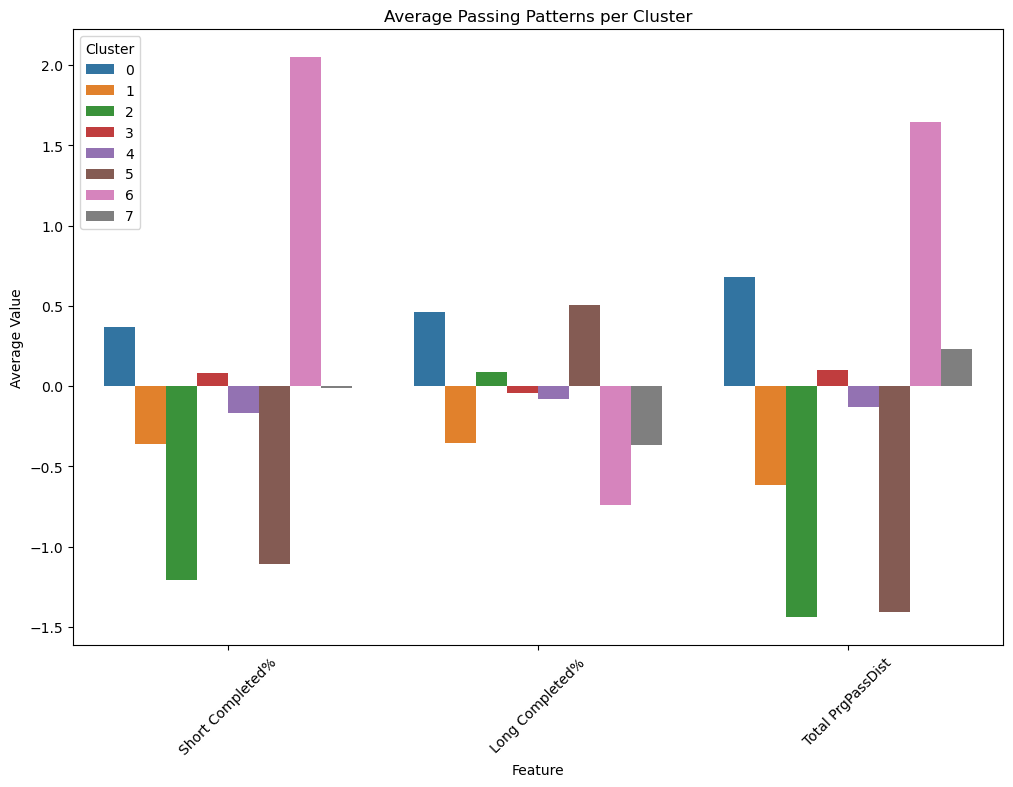

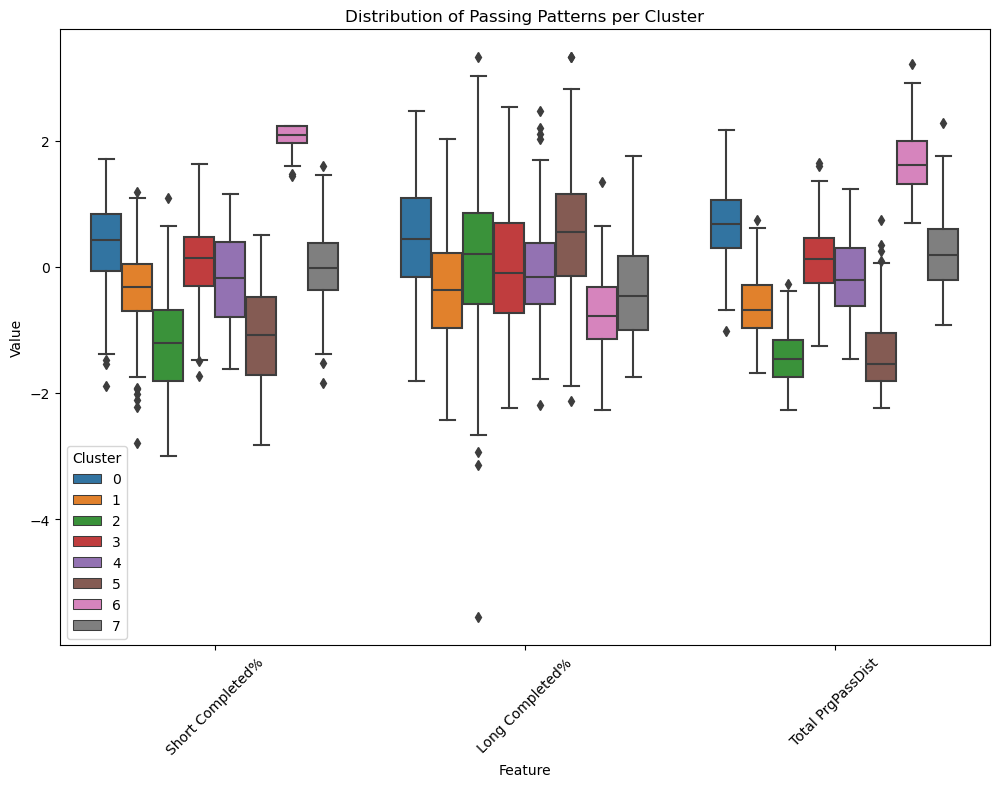

KeyError: "Columns not found: 'Clearances', 'Touches Def 3rd'"

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
# Assuming you have a DataFrame 'df' with your data and 'Cluster' as the cluster label
# Create a list of features for passing patterns and defending styles
passing_features = ['Short Completed%', 'Long Completed%', 'Total PrgPassDist']
defending_features = ['Clearances', 'Shots Blocked', 'Touches Def 3rd', 'Touches Def Penalty Area', 'challenge success%']

# Create a function to plot bar charts for average feature values per cluster
def plot_avg_feature_per_cluster(df, features, title):
    cluster_means = df.groupby('Cluster')[features].mean().reset_index()
    melted_cluster_means = pd.melt(cluster_means, id_vars='Cluster', var_name='Feature', value_name='Average Value')
    
    plt.figure(figsize=(12, 8))
    sns.barplot(data=melted_cluster_means, x='Feature', y='Average Value', hue='Cluster')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.legend(title='Cluster')
    plt.show()

# Create a function to plot box plots for feature distributions per cluster
def plot_feature_distribution_per_cluster(df, features, title):
    melted_df = pd.melt(df, id_vars='Cluster', value_vars=features, var_name='Feature', value_name='Value')
    
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=melted_df, x='Feature', y='Value', hue='Cluster')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.legend(title='Cluster')
    plt.show()

# Plotting the passing patterns
plot_avg_feature_per_cluster(df, passing_features, 'Average Passing Patterns per Cluster')
plot_feature_distribution_per_cluster(df, passing_features, 'Distribution of Passing Patterns per Cluster')

# Plotting the defending styles
plot_avg_feature_per_cluster(df, defending_features, 'Average Defending Styles per Cluster')
plot_feature_distribution_per_cluster(df, defending_features, 'Distribution of Defending Styles per Cluster')